## Selection of filters for the model

### Contents
* [Task description](#Task-description)
* [Model description](#Model-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters value area](#Parameters-value-area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Dataset bypass](#Dataset-bypass)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

### Task description
Select the parameters for Unet architecture, to suppress noise on the seismograms.

### Model description
layout dictionary:
* __c__ - 1d-convolutional block.
* __a__ - activation function.
* __d__ - dropout layer.
* __t__ - 1d-transposed convolition.

This is a Unet-like architecture with following blocks:
* Encoder:
    
    Encoder could be decsribed by layout _ca ca_ where:
    * c - block:
        - kernel size = 7
    * activation - relu
* Decoder:
    
    Decoders' layout is _ca ca_ where:
    * c - block:
        - kernel size = 7
    * activation - _relu_
* Downsample:
    
    Downsamples' layout is _p d_ where:
    * p - block:
        - pool_size = 2
        - pool_stride = 2
    * d -block:
        - dropout_rate = 0.05
* Upsample:
    
    Upsamples' layout is _tad_ where:
    * t - block:
        - kernel_size = 7
        - strides = 2
    * d -block:
        - dropout_rate = 0.05
    * activation - _relu_
    
### The parameters studied
A number of filters

### Parameters value area
A number of filters: [[8, 16, 32, 64, 128],
                       [4, 8, 16, 32, 64],
                       [16, 32, 64, 128, 256]]
                       
### Metrics
Pixel-based difference module between prediction and target.

### Dataset loading
Dataset is given by 2 SEGY files with a seismogram before and after ground-roll attenuation according to LIFT procedure. The seismorgam contains 176K traces combined in 51 field records. 

First, we index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F, C
from seismicpro.batchflow.models.tf import UNet
from seismicpro.batchflow.research import Research, Option
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)


plt.style.use('ggplot')

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Dataset bypass:
* Define model config
* Define index and train / test.

In [2]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': C('filters'),#
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

In [3]:
train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

Create an instance of train and test pipelines.

In [4]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1),
                          'y': np.expand_dims(np.vstack(batch.lift), -1)}}
B_SIZE = 128
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=float)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='w')
                  .run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)
                 ) << train_set

test_pipeline = (Pipeline()
                    .import_model('unet', C('import_from'))
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000), fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                    .run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)
                   ) << test_set

Define of auxiliary functions.

In [5]:
def get_mape(iteration, experiment, pipeline):
    """ Calculate mean absolute percentage error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    res = np.squeeze(np.vstack(pipeline.get_variable("res")), axis=-1)
    lift = np.vstack(np.concatenate(pipeline.get_variable("lift")))
    return np.mean(np.abs(res - lift))

def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)

### Creating a research object
After pipeline creation let's define reserach instance.

In [6]:
opts = Option('filters', [[8, 16, 32, 64, 128],
                          [4, 8, 16, 32, 64],
                          [16, 32, 64, 128, 256]])
research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape, returns='metrics', name='mape',
                      execute='%5', pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='unet', path='saved_models/')
)

In [8]:
NUM_REPEAT = 3
NUM_ITERS = 500
research_name = 'reserach_filter'

In [9]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, workers=5, gpu=[1, 2, 3, 6, 7], progress_bar=True)

Research reserach_filter_9 is starting...


  0%|          | 0/4500 [00:00<?, ?it/s]

Distributor has 9 jobs with 500 iterations. Totally: 4500
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 49%|████▉     | 2196/4500 [05:19<05:35,  6.87it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 49%|████▉     | 2226/4500 [05:25<05:32,  6.85it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 55%|█████▍    | 2464/4500 [06:03<05:00,  6.78it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


 55%|█████▌    | 2478/4500 [06:07<04:59,  6.74it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|██████████| 4500/4500 [14:25<00:00,  5.20it/s]


In [10]:
df = research.load_results(use_alias=True)

In [11]:
def show_research(df, layout=None, average_repetitions=False, log_scale=False, rolling_window=None):
    """Show plots given by research dataframe."""
    if layout is None:
        layout = []
        for nlabel, ndf in df.groupby("name"):
            ndf = ndf.drop(['config', 'name', 'iteration', 'repetition'], axis=1).dropna(axis=1)
            for attr in ndf.columns.values:
                layout.append('/'.join([str(nlabel), str(attr)]))
    if type(log_scale) is bool:
        log_scale = [log_scale] * len(layout)
    if (type(rolling_window) is int) or (rolling_window is None):
        rolling_window = [rolling_window] * len(layout)
    rolling_window = [x if x is not None else 1 for x in rolling_window]

    fig, ax = plt.subplots(1, len(layout), figsize=(9 * len(layout), 7))
    if len(layout) == 1:
        ax = (ax, )

    for i, (title, log, rw) in enumerate(list(zip(*[layout, log_scale, rolling_window]))):
        name, attr = title.split('/')
        ndf = df[df['name'] == name]
        for clabel, cdf in ndf.groupby("config"):
            cdf = cdf.drop(['config', 'name'], axis=1).dropna(axis=1).astype('float')
            if average_repetitions:
                idf = cdf.groupby('iteration').mean().drop('repetition', axis=1)
                y_values = idf[attr].rolling(rw).mean().values
                if log:
                    y_values = np.log(y_values)
                ax[i].plot(idf.index.values, y_values, label=str(clabel))
            else:
                for r, rdf in cdf.groupby('repetition'):
                    rdf = rdf.drop('repetition', axis=1)
                    y_values = rdf[attr].rolling(rw).mean().values
                    if log:
                        y_values = np.log(y_values)
                    ax[i].plot(rdf['iteration'].values, y_values,
                               label='/'.join([str(r), str(clabel)]))
        ax[i].set_xlabel('iteration')
        ax[i].set_title(title)
        ax[i].legend()
    plt.show()

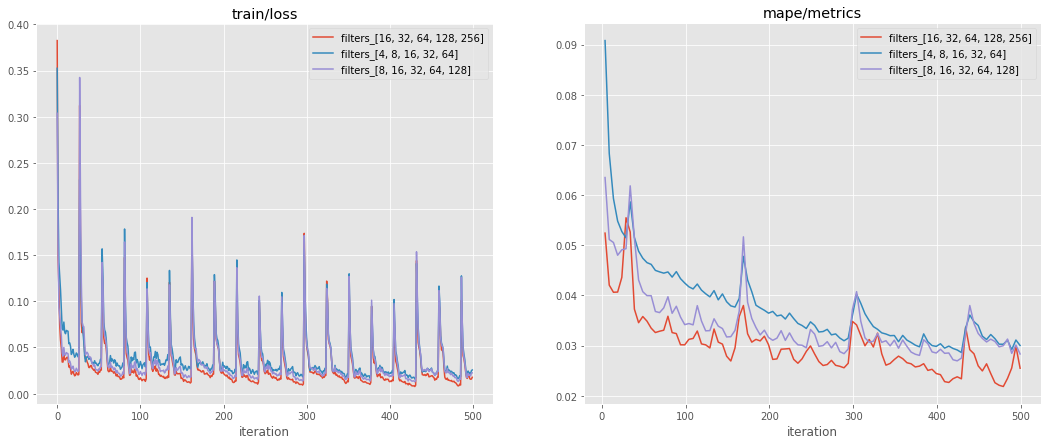

In [12]:
show_research(df, layout=['train/loss', 'mape/metrics'], average_repetitions=True)